# File has following components
    # Loads simple features from persistence saved in prior run (file Unified_7B)
    # Loads vit, resnet , and clip features extracted in prior run (file Unified_7B)
    # Runs best model from file Unified 7 (XGBoostClassifier, hyperparamaters: lr=0.3, max_depth=3, n_est=491)
    # Uses 80/20 train / test split, Stratified-k oversampling to address class imbalance, thresholding, full run on training (fit),
    # and then inference on hold out test

In [ ]:
# --- Install Required Packages ---
! pip install scikit-optimize
! pip install tqdm_joblib
! pip install umap-learn
! pip install PyWavelets
! pip install -q git+https://github.com/openai/CLIP.git
! pip install -q ftfy regex tqdm
! pip install imbalanced-learn


# --- Standard Library Imports ---
import numpy as np
from pathlib import Path
import os
import random
import re
import warnings
import multiprocessing


# --- Google Colab / IPython Imports ---
from google.colab import drive
from IPython.display import Image

# --- Third-Party Library Imports ---
import zipfile
import cv2
import cupy as cp
import cuml
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import torch
import logging
import umap
from joblib import Parallel, delayed
from scipy.stats import kurtosis, skew
from skimage import exposure
from skimage.color import rgb2gray
from skimage.feature import (
    hog, local_binary_pattern, graycomatrix, graycoprops
)
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from transformers import (
    ViTModel, ViTImageProcessor, ViTFeatureExtractor
)

# --- CuML Imports ---
from cuml.pipeline import Pipeline as cuPipeline
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.linear_model import LogisticRegression as cuLogReg
from cuml.model_selection import StratifiedKFold as cuStratifiedKFold
from cuml.neighbors import KNeighborsClassifier as cuKNeighbors
from cuml.svm import SVC as cuSVC

# --- Imbalanced-Learn Imports ---
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# --- Scikit-Optimize Imports ---
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

# --- Scikit-Learn Imports ---
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, f1_score
)
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

# --- XGBoost Imports ---
from xgboost import XGBClassifier

# --- Configuration ---
random.seed(42)
warnings.filterwarnings("ignore")

# Get the logger used by the cuml library and set its level
logging.getLogger('cuml').setLevel(logging.ERROR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.9 MB/s eta 0:00:00


In [ ]:
!pip install -q torch torchvision tqdm ftfy regex
!pip install -q git+https://github.com/openai/CLIP.git


  Preparing metadata (setup.py) ... done


In [ ]:
#some utility functions
def whoAmI(img):
    """
    Prints dtype, min, max, mean, height, and width of an image.
    """
    print(f"dtype     : {img.dtype}")
    print(f"min       : {np.min(img):.4f}")
    print(f"max       : {np.max(img):.4f}")
    print(f"mean      : {np.mean(img):.4f}")
    print(f"shape     : {img.shape}")
    if img.ndim == 2:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
    elif img.ndim == 3:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
        print(f"channels  : {img.shape[2]}")

#VS - II helpful functions

# summarizes a data frame in a printer friendly way
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes.values,
        'Null Count': df.isnull().sum().values,
        'Non-Null Count': df.notnull().sum().values,
        'Unique Count': df.nunique().values
    })
    return summary

def plot_training_history(history):
    """
    Plots training and validation loss & accuracy from a Keras history object.

    Parameters:
    - history: Keras history object from model.fit()
    """

    epochs = range(1, len(history.history['loss']) + 1)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']


    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='-')
    ax[0].plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='-')
    ax[1].plot(epochs, val_acc, label='Validation Accuracy', color='red', linestyle='--')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()



# Load saved feature vectors

In [ ]:
import numpy as np
from pathlib import Path

def mount_google_drive():
    """
    Mounts the user's Google Drive in a Colab environment.
    Returns the root mount path as a Path object.
    """
    from google.colab import drive
    from pathlib import Path

    print("Mounting Google Drive...")
    drive.mount('/content/drive', force_remount=True)
    drive_path = Path("/content/drive/MyDrive")
    print(f"Google Drive mounted at: {drive_path}")
    return drive_path

def load_vit_features():
    file_path = Path("/content/drive/MyDrive/w81_fp/vit_feature_set_all.npz")
    data = np.load(file_path, allow_pickle=True)
    print(" Loaded ViT features. Keys:", data.files)
    return data

def load_resnet_features():
    file_path = Path("/content/drive/MyDrive/w81_fp/resnet_features_with_ids.npz")
    data = np.load(file_path, allow_pickle=True)
    print(" Loaded ResNet features. Keys:", data.files)
    return data

def load_clip_features():
    file_path = Path("/content/drive/MyDrive/w81_fp/clip_features_with_ids.npz")
    data = np.load(file_path, allow_pickle=True)
    print(" Loaded CLIP features. Keys:", data.files)
    return data

def load_simple_features():
    file_path = Path("/content/drive/MyDrive/w81_fp/simple_feature_set_all.npz")
    data = np.load(file_path, allow_pickle=True)
    print("Loaded Simple features. Keys:", data.files)
    return data


In [ ]:
mount_google_drive()

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted at: /content/drive/MyDrive


PosixPath('/content/drive/MyDrive')

In [ ]:
# # Load the .npz file
#vit, color,hsv Gabor,lbp
data_simple_features = load_simple_features()
print("Available keys:", data_simple_features.files)

# Extract all feature arrays
X_hog       = data_simple_features['X_hog']
X_hsv       = data_simple_features['X_hsv']
X_lbp       = data_simple_features['X_lbp']
X_color     = data_simple_features['X_color']
X_intensity = data_simple_features['X_intensity']
X_glcm      = data_simple_features['X_glcm']
X_gabor     = data_simple_features['X_gabor']
X_shape     = data_simple_features['X_shape']
X_corners   = data_simple_features['X_corners']
X_sift      = data_simple_features['X_sift']
X_wavelet   = data_simple_features['X_wavelet']
X_sobel     = data_simple_features['X_sobel']

# Also load metadata_simple_features
labels      = data_simple_features['labels'].tolist()
image_ids   = data_simple_features['image_ids'].tolist()


# Summary
print(" Loaded simple feature vectors.")
print("color shape:", X_color.shape)
print("HSV shape:", X_hsv.shape)
print("gabor shape:", X_gabor.shape)
print("LBP shape:", X_lbp.shape)
print("glcm shape:", X_glcm.shape)
print("Labels loaded:", len(labels))


Loaded Simple features. Keys: ['X_hog', 'X_hsv', 'X_lbp', 'X_color', 'X_intensity', 'X_glcm', 'X_gabor', 'X_shape', 'X_corners', 'X_sift', 'X_wavelet', 'X_sobel', 'labels', 'image_ids']
Available keys: ['X_hog', 'X_hsv', 'X_lbp', 'X_color', 'X_intensity', 'X_glcm', 'X_gabor', 'X_shape', 'X_corners', 'X_sift', 'X_wavelet', 'X_sobel', 'labels', 'image_ids']
 Loaded simple feature vectors.
color shape: (10015, 518)
HSV shape: (10015, 1024)
gabor shape: (10015, 48)
LBP shape: (10015, 10)
glcm shape: (10015, 6)
Labels loaded: 10015


In [ ]:
labels[:5]

['bkl', 'bkl', 'bkl', 'bkl', 'bkl']

In [ ]:
# Encode Labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
class_mapping


{0: np.str_('akiec'),
 1: np.str_('bcc'),
 2: np.str_('bkl'),
 3: np.str_('df'),
 4: np.str_('mel'),
 5: np.str_('nv'),
 6: np.str_('vasc')}

In [ ]:
data_vit = load_vit_features()
data_resnet = load_resnet_features()
data_clip = load_clip_features()

 Loaded ViT features. Keys: ['X_vit', 'labels', 'image_ids']
 Loaded ResNet features. Keys: ['X_resnet', 'labels', 'image_ids']
 Loaded CLIP features. Keys: ['X_clip', 'labels', 'image_ids']


In [ ]:
X_vit = data_vit['X_vit']
X_resnet = data_resnet['X_resnet']
X_clip = data_clip['X_clip']

In [ ]:
whoAmI(X_vit)

dtype     : float32
min       : -0.9224
max       : 0.9147
mean      : -0.0176
shape     : (10015, 768)
height    : 10015
width     : 768


In [ ]:
whoAmI(X_resnet)

dtype     : float32
min       : 0.0000
max       : 8.1364
mean      : 0.3612
shape     : (10015, 2048)
height    : 10015
width     : 2048


In [ ]:
whoAmI(X_clip)

dtype     : float16
min       : -8.9844
max       : 4.3125
mean      : -0.0266
shape     : (10015, 512)
height    : 10015
width     : 512


In [ ]:
whoAmI(X_color)

dtype     : float64
min       : 0.0000
max       : 254.2366
mean      : 1.0977
shape     : (10015, 518)
height    : 10015
width     : 518


In [ ]:
whoAmI(X_hsv)

dtype     : float32
min       : 0.0000
max       : 0.9998
mean      : 0.0024
shape     : (10015, 1024)
height    : 10015
width     : 1024


In [ ]:
whoAmI(X_gabor)

dtype     : float64
min       : 0.0000
max       : 255.0000
mean      : 84.4235
shape     : (10015, 48)
height    : 10015
width     : 48


In [ ]:
whoAmI(X_lbp)

dtype     : float64
min       : 0.0133
max       : 0.2821
mean      : 0.1000
shape     : (10015, 10)
height    : 10015
width     : 10


In [ ]:
## Scale simple features because deep features are scaled
from sklearn.preprocessing import StandardScaler

scaler_color = StandardScaler().fit(X_color)
scaler_hsv   = StandardScaler().fit(X_hsv)
scaler_gabor = StandardScaler().fit(X_gabor)
scaler_lbp   = StandardScaler().fit(X_lbp)

X_color_scaled = scaler_color.transform(X_color)
X_hsv_scaled   = scaler_hsv.transform(X_hsv)
X_gabor_scaled = scaler_gabor.transform(X_gabor)
X_lbp_scaled   = scaler_lbp.transform(X_lbp)


In [ ]:
#vit, color,hsv Gabor,lbp

X_combined_vit = np.hstack([X_vit, X_color_scaled, X_hsv_scaled, X_gabor_scaled, X_lbp_scaled])
X_combined_resnet = np.hstack([X_resnet, X_color_scaled, X_hsv_scaled, X_gabor_scaled, X_lbp_scaled])
X_combined_clip = np.hstack([X_clip, X_color_scaled, X_hsv_scaled, X_gabor_scaled, X_lbp_scaled])


In [ ]:
whoAmI(X_combined_vit)

dtype     : float64
min       : -23.8167
max       : 100.0700
mean      : -0.0057
shape     : (10015, 2368)
height    : 10015
width     : 2368


In [ ]:
whoAmI(X_combined_resnet)

dtype     : float64
min       : -23.8167
max       : 100.0700
mean      : 0.2028
shape     : (10015, 3648)
height    : 10015
width     : 3648


In [ ]:
whoAmI(X_combined_clip)

dtype     : float64
min       : -23.8167
max       : 100.0700
mean      : -0.0065
shape     : (10015, 2112)
height    : 10015
width     : 2112


In [ ]:
whoAmI(y)

dtype     : int64
min       : 0.0000
max       : 6.0000
mean      : 4.1823
shape     : (10015,)


In [ ]:
y[:5]

array([2, 2, 2, 2, 2])

# XGBoostClassifier - lr=0.3, max_depth=3, n_est=491
    80/20 train / test
    Stratified k fold, with random oversampling on training folds
    Threshold tuning
    Run on full training data set
    Get test inference metrics

In [ ]:
import pickle
from pathlib import Path

# --- Save Results ---
def save_results_to_drive(results, filename="results_sf_vit.pkl", folder="/content/drive/MyDrive/w81_fp"):
    """
    Saves the results dictionary (including model) to Google Drive as a .pkl file.
    """
    path = Path(folder) / filename
    with open(path, "wb") as f:
        pickle.dump(results, f)
    print(f"[✓] Saved results to: {path}")

# --- Load Results ---
def load_results_from_drive(filename="results_sf_vit.pkl", folder="/content/drive/MyDrive/w81_fp"):
    """
    Loads the saved .pkl results file from Google Drive.
    """
    path = Path(folder) / filename
    with open(path, "rb") as f:
        results = pickle.load(f)
    print(f"[✓] Loaded results from: {path}")
    return results

# Example usage:
# save_results_to_drive(results_sf_vit)
# loaded_results = load_results_from_drive()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score,
    balanced_accuracy_score, f1_score
)
from imblearn.over_sampling import RandomOverSampler

# --- Helper: Tune optimal threshold ---
def tune_confidence_threshold_multiclass(probs, y_true, thresholds=np.linspace(0.1, 0.9, 81)):
    best_threshold = 0.5
    best_f1 = 0.0

    for T in thresholds:
        y_pred = []
        for p in probs:
            if np.max(p) >= T:
                y_pred.append(np.argmax(p))
            else:
                y_pred.append(-1)

        y_pred = np.array(y_pred)
        mask = (y_pred != -1)
        if np.sum(mask) == 0:
            continue

        f1 = f1_score(y_true[mask], y_pred[mask], average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = T

    return best_threshold, best_f1

# --- Main function: Training + Threshold Tuning + Evaluation ---
def run_f1_gpu_with_threshold_tuning_ros(model, X, y, n_splits=5, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    num_classes = len(np.unique(y))
    probs_oof = np.zeros((len(y_train), num_classes))
    y_true_oof = np.array(y_train)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        ros = RandomOverSampler(sampling_strategy="not majority", random_state=random_state)
        X_tr_resampled, y_tr_resampled = ros.fit_resample(X_tr, y_tr)

        model.fit(X_tr_resampled, y_tr_resampled)
        probs_oof[val_idx] = model.predict_proba(X_val)

    tuned_threshold, _ = tune_confidence_threshold_multiclass(probs_oof, y_true_oof)

    ros = RandomOverSampler(sampling_strategy="not majority", random_state=random_state)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    best_model = model.fit(X_train_resampled, y_train_resampled)

    y_test_pred_proba = best_model.predict_proba(X_test)
    y_test_pred = [
        np.argmax(p) if np.max(p) >= tuned_threshold else -1 for p in y_test_pred_proba
    ]
    y_test_pred = np.array(y_test_pred)
    mask = y_test_pred != -1

    report_dict = classification_report(y_test[mask], y_test_pred[mask], output_dict=True)
    test_auc = roc_auc_score(y_test[mask], y_test_pred_proba[mask], multi_class="ovr", average="macro")

    test_metrics = {
        "roc_auc_macro": test_auc,
        "accuracy": accuracy_score(y_test[mask], y_test_pred[mask]),
        "balanced_accuracy": balanced_accuracy_score(y_test[mask], y_test_pred[mask]),
        "precision_macro": report_dict["macro avg"]["precision"],
        "recall_macro": report_dict["macro avg"]["recall"],
        "f1_macro": report_dict["macro avg"]["f1-score"],
        "precision_weighted": report_dict["weighted avg"]["precision"],
        "recall_weighted": report_dict["weighted avg"]["recall"],
        "f1_weighted": report_dict["weighted avg"]["f1-score"],
    }

    final_results = {
        "best_model": best_model,
        "test_set_report": pd.DataFrame(report_dict).transpose(),
        "test_set_metrics": test_metrics,
        "best_cv_f1_macro": f1_score(y_true_oof, np.argmax(probs_oof, axis=1), average="macro"),
        "test_set_roc_auc": test_auc,
        "tuned_threshold": tuned_threshold,
        "used_model_params": model.get_params(),

        # Added for ROC plotting
        "y_test": y_test,
        "y_test_pred_proba": y_test_pred_proba,
    }

    return final_results


In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    learning_rate=0.3,
    max_depth=3,
    n_estimators=491,
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)



In [ ]:
results_sf_vit = run_f1_gpu_with_threshold_tuning_ros(xgb_model, X=X_combined_vit, y=y)

In [ ]:
save_results_to_drive(results_sf_vit)


[✓] Saved results to: /content/drive/MyDrive/w81_fp/results_sf_vit.pkl


In [ ]:
loaded_results_vit = load_results_from_drive()

[✓] Loaded results from: /content/drive/MyDrive/w81_fp/results_sf_vit.pkl


In [ ]:
results_sf_resnet = run_f1_gpu_with_threshold_tuning_ros(xgb_model, X=X_combined_resnet, y=y)

save_results_to_drive(results=results_sf_resnet, filename="results_sf_resnet.pkl")
loaded_results_resnet = load_results_from_drive(filename="results_sf_resnet.pkl")


NameError: name 'run_f1_gpu_with_threshold_tuning_ros' is not defined

In [ ]:
results_sf_clip = run_f1_gpu_with_threshold_tuning_ros(xgb_model, X=X_combined_clip, y=y)

save_results_to_drive(results=results_sf_clip, filename="results_sf_clip.pkl")
loaded_results_clip = load_results_from_drive(filename="results_sf_clip.pkl")

[✓] Saved results to: /content/drive/MyDrive/w81_fp/results_sf_clip.pkl
[✓] Loaded results from: /content/drive/MyDrive/w81_fp/results_sf_clip.pkl


In [ ]:
summary_df = pd.DataFrame([
    {
        "Model": "ViT",
        "Best CV F1-Macro": results_sf_vit["best_cv_f1_macro"],
        "Test AUC-ROC": results_sf_vit["test_set_roc_auc"],
        "Test Accuracy": results_sf_vit["test_set_metrics"]["accuracy"],
        "Test F1-Macro": results_sf_vit["test_set_metrics"]["f1_macro"],
    },
    {
        "Model": "ResNet",
        "Best CV F1-Macro": results_sf_resnet["best_cv_f1_macro"],
        "Test AUC-ROC": results_sf_resnet["test_set_roc_auc"],
        "Test Accuracy": results_sf_resnet["test_set_metrics"]["accuracy"],
        "Test F1-Macro": results_sf_resnet["test_set_metrics"]["f1_macro"],
    },
    {
        "Model": "CLIP",
        "Best CV F1-Macro": results_sf_clip["best_cv_f1_macro"],
        "Test AUC-ROC": results_sf_clip["test_set_roc_auc"],
        "Test Accuracy": results_sf_clip["test_set_metrics"]["accuracy"],
        "Test F1-Macro": results_sf_clip["test_set_metrics"]["f1_macro"],
    }
])

# Display the summary
summary_df

,Model,Best CV F1-Macro,Test AUC-ROC,Test Accuracy,Test F1-Macro
0,ViT,0.682016,0.982986,0.938124,0.857187
1,ResNet,0.628186,0.974642,0.924983,0.799887
2,CLIP,0.617616,0.976536,0.923395,0.784727


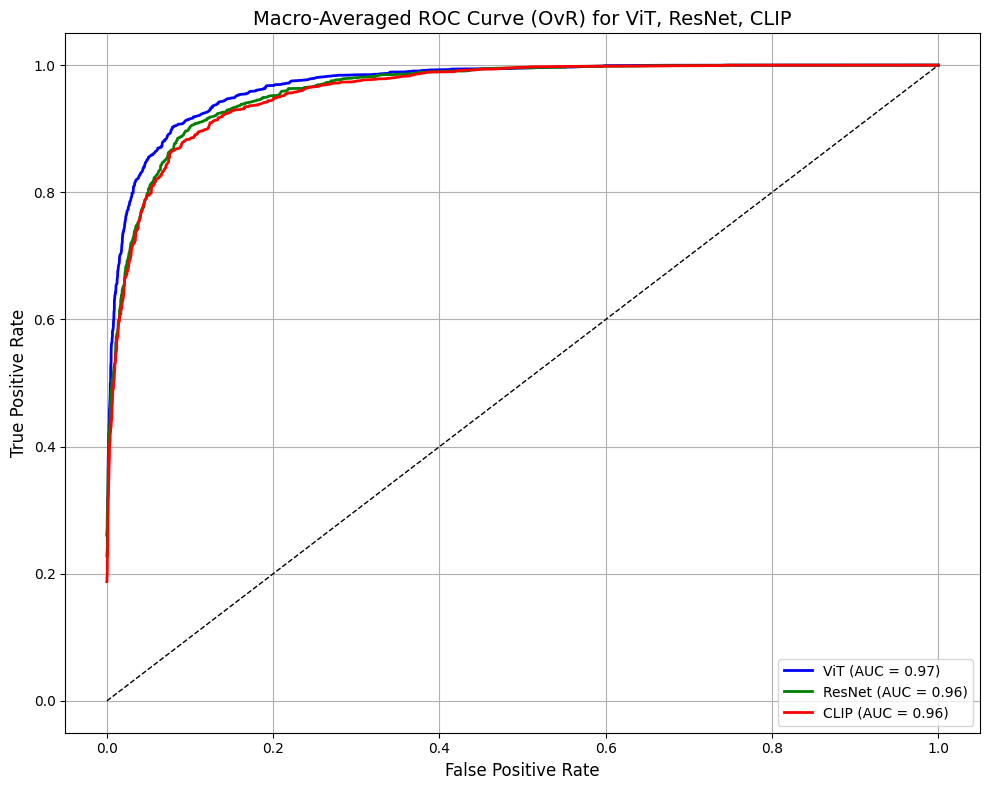

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# --- Step 1: Collect results from all models ---
all_results = {
    "ViT": results_sf_vit,
    "ResNet": results_sf_resnet,
    "CLIP": results_sf_clip,
}

# --- Step 2: Setup ---
n_classes = len(np.unique(results_sf_vit["y_test"]))
colors = {
    "ViT": "blue",
    "ResNet": "green",
    "CLIP": "red",
}

plt.figure(figsize=(10, 8))

# --- Step 3: Compute ROC Curve for each model ---
for name, result in all_results.items():
    y_true = result["y_test"]
    y_score = result["y_test_pred_proba"]

    # Binarize y for multiclass OvR ROC
    y_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute per-class ROC and average
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # Plot
    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {macro_auc:.2f})", linewidth=2, color=colors[name])

# --- Step 4: Formatting ---
plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Macro-Averaged ROC Curve (OvR) for ViT, ResNet, CLIP", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Run classification report and class based performanc on Vit



*   Load saved ViT Model and results
*   Executed desired reports and tables



In [ ]:
import pickle
from pathlib import Path

def load_results_from_drive(filename="results_sf_vit.pkl", folder="/content/drive/MyDrive/w81_fp"):
    """
    Loads the saved .pkl results file from Google Drive.
    """
    path = Path(folder) / filename
    with open(path, "rb") as f:
        results = pickle.load(f)
    print(f"[✓] Loaded results from: {path}")
    return results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
results_sf_vit = load_results_from_drive(filename="results_sf_vit.pkl")


[✓] Loaded results from: /content/drive/MyDrive/w81_fp/results_sf_vit.pkl


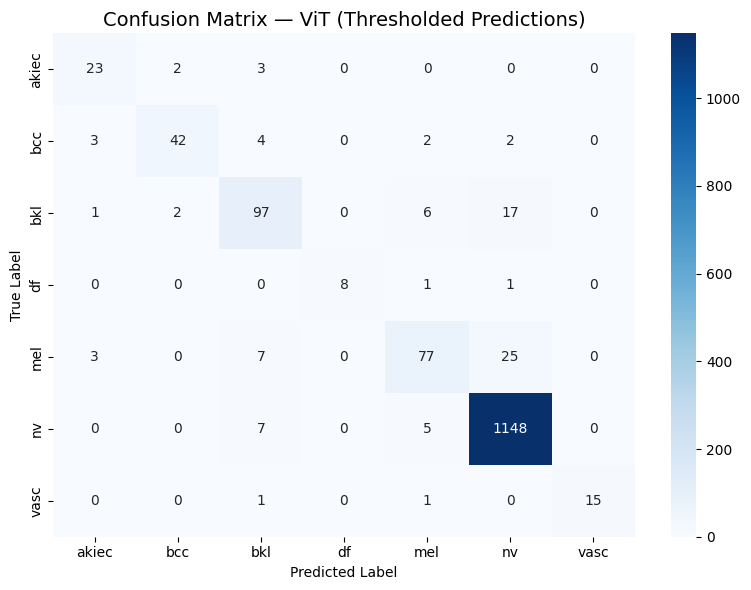

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from pathlib import Path
import pickle

df_report_vit = results_sf_vit["test_set_report"]
y_test = results_sf_vit["y_test"]
y_pred_proba = results_sf_vit["y_test_pred_proba"]
threshold = results_sf_vit["tuned_threshold"]

# --- Convert probabilities to predictions using tuned threshold ---
y_pred = np.array([
    np.argmax(p) if np.max(p) >= threshold else -1
    for p in y_pred_proba
])

# --- Mask to exclude uncertain predictions (rejected by threshold) ---
mask = y_pred != -1
y_test_masked = y_test[mask]
y_pred_masked = y_pred[mask]

# --- Compute confusion matrix ---
cm = confusion_matrix(y_test_masked, y_pred_masked)

# --- Class names for HAM10000 (adjust to your label order) ---
ham10000_class_names = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]

# --- Plot heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=ham10000_class_names, yticklabels=ham10000_class_names)
plt.title("Confusion Matrix — ViT (Thresholded Predictions)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
# --- Per-class metrics from saved classification report ---
df_report = results_sf_vit["test_set_report"]

# --- HAM10000 class names in same order as label encoding (adjust if needed) ---
ham10000_class_names = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
index_map = {str(i): name for i, name in enumerate(ham10000_class_names)}

# --- Rename integer string indices to class names ---
df_report_named = df_report.rename(index=index_map)

# --- Extract precision, recall, f1-score, and support ---
df_per_class = df_report_named.loc[ham10000_class_names, ["precision", "recall", "f1-score", "support"]]
df_per_class[["precision", "recall", "f1-score"]] = df_per_class[["precision", "recall", "f1-score"]].round(4)
df_per_class["support"] = df_per_class["support"].astype(int)

# --- Display ---
print("Per-Class Metrics with Support:")
print(df_per_class)


Per-Class Metrics with Support:
       precision  recall  f1-score  support
akiec     0.7667  0.8214    0.7931       28
bcc       0.9130  0.7925    0.8485       53
bkl       0.8151  0.7886    0.8017      123
df        1.0000  0.8000    0.8889       10
mel       0.8370  0.6875    0.7549      112
nv        0.9623  0.9897    0.9758     1160
vasc      1.0000  0.8824    0.9375       17
